## CSC420 - Assignment 3

## Humzah Khan

#### Question 3 - Local Descriptors: HOGS (70)

Exploration of Image Gradients, and Directions

Saving prof_pic.jpg to prof_pic (1).jpg


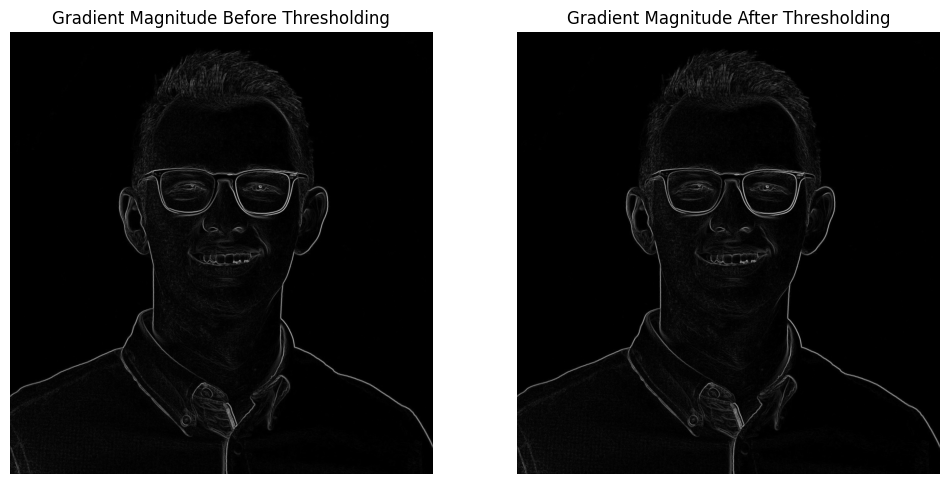

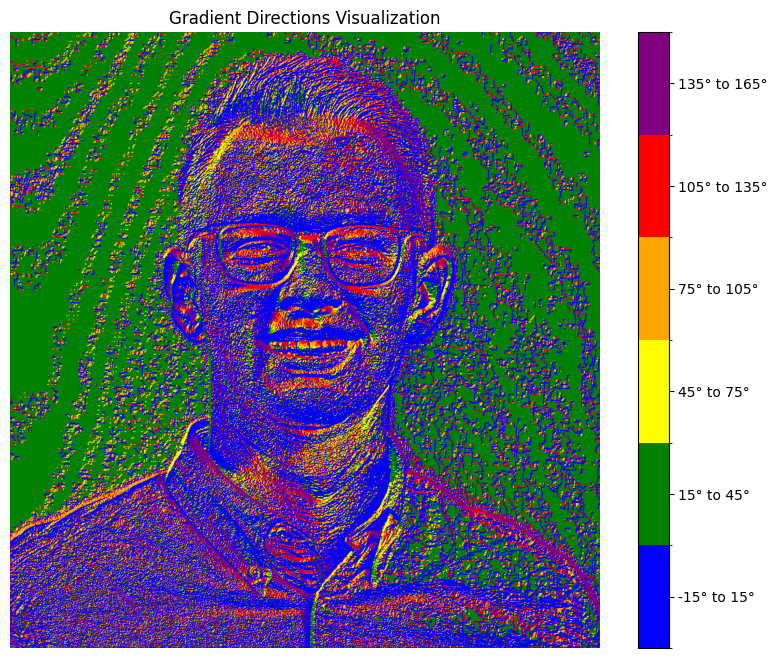

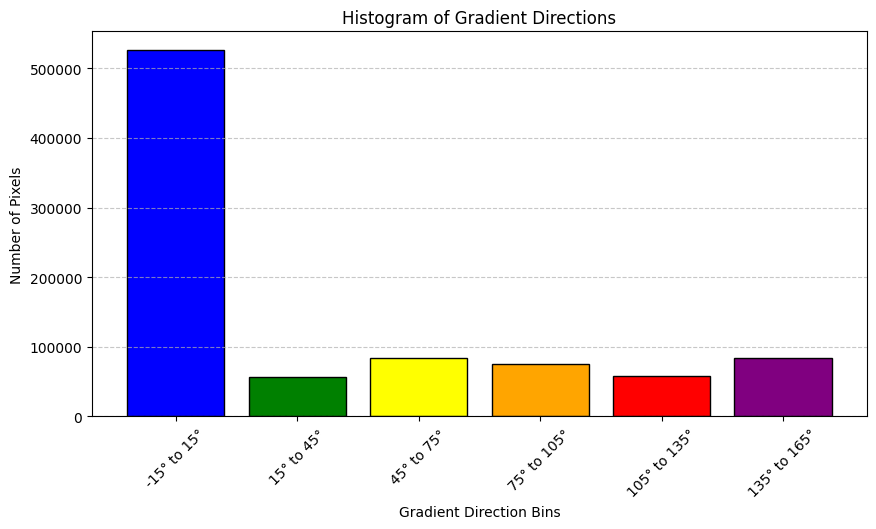

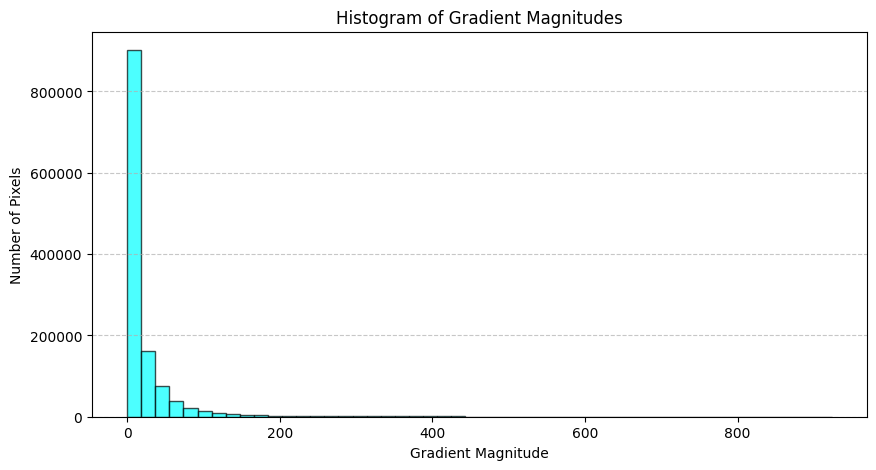

In [60]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Upload and Read Image (You can also use your own image file)
from google.colab import files

uploaded = files.upload()  # Upload an image file manually
image_path = list(uploaded.keys())[0]

# Load the image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


# Compute gradients using Sobel operators
Gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
Gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

# Compute gradient magnitude and direction
magnitude = np.sqrt(Gx**2 + Gy**2)
direction = np.arctan2(Gy, Gx) * (180 / np.pi)  # Convert radians to degrees

# Store the original magnitude for visualization
magnitude_before_threshold = magnitude.copy()

# Threshold small gradient magnitudes
threshold = 5  # Adjustable threshold value
magnitude[magnitude < threshold] = 0

# Plot the magnitude before and after thresholding
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Magnitude before thresholding
axes[0].imshow(magnitude_before_threshold, cmap='gray')
axes[0].set_title("Gradient Magnitude Before Thresholding")
axes[0].axis("off")

# Magnitude after thresholding
axes[1].imshow(magnitude, cmap='gray')
axes[1].set_title("Gradient Magnitude After Thresholding")
axes[1].axis("off")

plt.show()

# Define cell size for segmentation
cell_size = 20
height, width = gray.shape
cell_rows, cell_cols = height // cell_size, width // cell_size

# Quantization of orientation into 6 bins
angle_bins = np.array([-15, 15, 45, 75, 105, 135, 165])  # Bin edges
num_bins = len(angle_bins) - 1
histogram = np.zeros((cell_rows, cell_cols, num_bins))

import matplotlib.colors as mcolors
bin_labels = ["-15° to 15°", "15° to 45°", "45° to 75°", "75° to 105°", "105° to 135°", "135° to 165°"]
colors = ['blue', 'green', 'yellow', 'orange', 'red', 'purple']  # Assign colors to bins

# Assign a color to each pixel based on its gradient direction
direction_colored = np.zeros(gray.shape, dtype=np.uint8)

for i in range(len(angle_bins) - 1):
    mask = (direction >= angle_bins[i]) & (direction < angle_bins[i + 1])
    direction_colored[mask] = i + 1  # Assign bin index (1 to 6)

# Create a colormap for visualization
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(len(angle_bins))  # Bin boundaries
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the gradient direction visualization
fig, ax = plt.subplots(figsize=(10, 8))
img_plot = ax.imshow(direction_colored, cmap=cmap, norm=norm)
ax.set_title("Gradient Directions Visualization")
ax.axis("off")

# Create a color legend
cbar = plt.colorbar(img_plot, ticks=np.arange(len(bin_labels)) + 0.5)
cbar.set_ticklabels(bin_labels)

plt.show()

import matplotlib.pyplot as plt

# Histogram of gradient directions (count per bin)
direction_histogram = np.zeros(len(angle_bins) - 1)
for i in range(len(angle_bins) - 1):
    mask = (direction >= angle_bins[i]) & (direction < angle_bins[i + 1])
    direction_histogram[i] = np.sum(mask)  # Count number of pixels in each bin

# Plot histogram of gradient directions
plt.figure(figsize=(10, 5))
plt.bar(bin_labels, direction_histogram, color=colors, edgecolor="black")
plt.xlabel("Gradient Direction Bins")
plt.ylabel("Number of Pixels")
plt.title("Histogram of Gradient Directions")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot histogram of gradient magnitudes
plt.figure(figsize=(10, 5))
plt.hist(magnitude.ravel(), bins=50, color="cyan", edgecolor="black", alpha=0.7)
plt.xlabel("Gradient Magnitude")
plt.ylabel("Number of Pixels")
plt.title("Histogram of Gradient Magnitudes")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



### Summed Gradient Approach

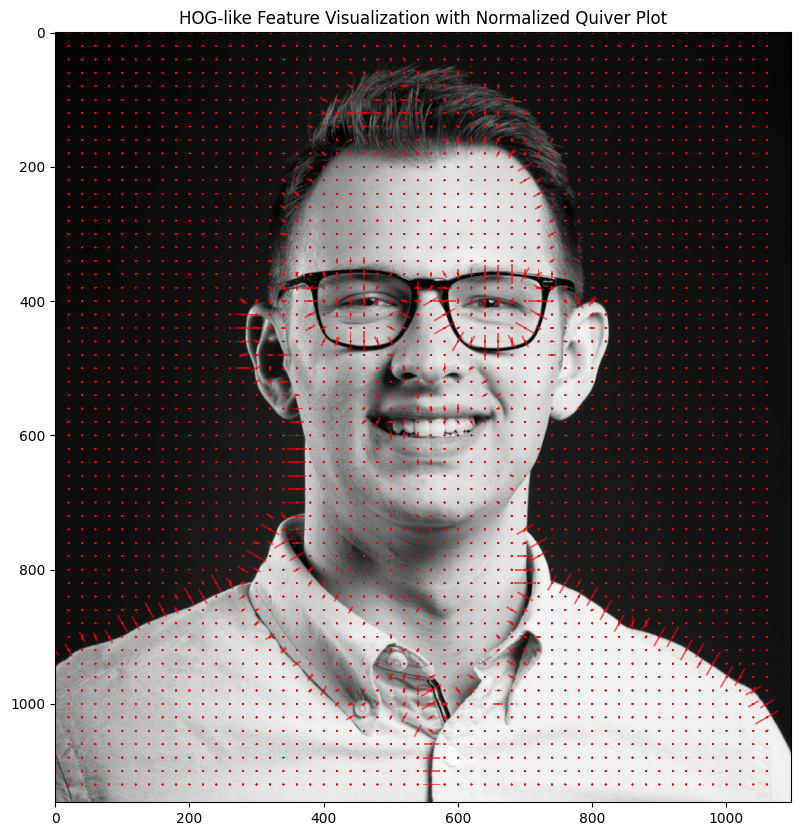

In [61]:
# Fill the histogram with accumulated magnitudes
for i in range(cell_rows):
    for j in range(cell_cols):
        # Extract gradients for the cell
        cell_magnitude = magnitude[i * cell_size: (i + 1) * cell_size,
                                   j * cell_size: (j + 1) * cell_size]
        cell_direction = direction[i * cell_size: (i + 1) * cell_size,
                                   j * cell_size: (j + 1) * cell_size]

        # Quantize the directions into bins
        for k in range(num_bins):
            mask = (cell_direction >= angle_bins[k]) & (cell_direction < angle_bins[k + 1])
            histogram[i, j, k] = np.sum(cell_magnitude[mask])

# Visualization using quiver plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(gray, cmap='gray')

# Superimpose quiver plots
X, Y = np.meshgrid(np.arange(cell_cols) * cell_size, np.arange(cell_rows) * cell_size)

# Normalize histogram values to a reasonable range
histogram_max = np.max(histogram)  # Find max value for scaling
histogram_min = np.min(histogram[histogram > 0])  # Smallest nonzero value
histogram_norm = (histogram - histogram_min) / (histogram_max - histogram_min + 1e-5)  # Normalize between 0 and 1

# Scale factor to make arrows visible (adjust as needed)
arrow_scale = 20

for k in range(num_bins):
    angle = (angle_bins[k] + angle_bins[k + 1]) / 2  # Midpoint of bin range
    U = np.cos(np.radians(angle)) * histogram_norm[:, :, k] * arrow_scale
    V = np.sin(np.radians(angle)) * histogram_norm[:, :, k] * arrow_scale
    ax.quiver(X, Y, U, V, color='r', angles='xy', scale_units='xy', scale=1, alpha=0.6, headwidth=0, headlength=0, headaxislength=0)

for k in range(num_bins):
    angle = (angle_bins[k] + angle_bins[k + 1]) / 2  + 180 # Midpoint of bin range
    U = np.cos(np.radians(angle)) * histogram_norm[:, :, k] * arrow_scale
    V = np.sin(np.radians(angle)) * histogram_norm[:, :, k] * arrow_scale
    ax.quiver(X, Y, U, V, color='r', angles='xy', scale_units='xy', scale=1, alpha=0.6, headwidth=0, headlength=0, headaxislength=0)


plt.title("HOG-like Feature Visualization with Normalized Quiver Plot")
plt.show()


### Occurences Approach

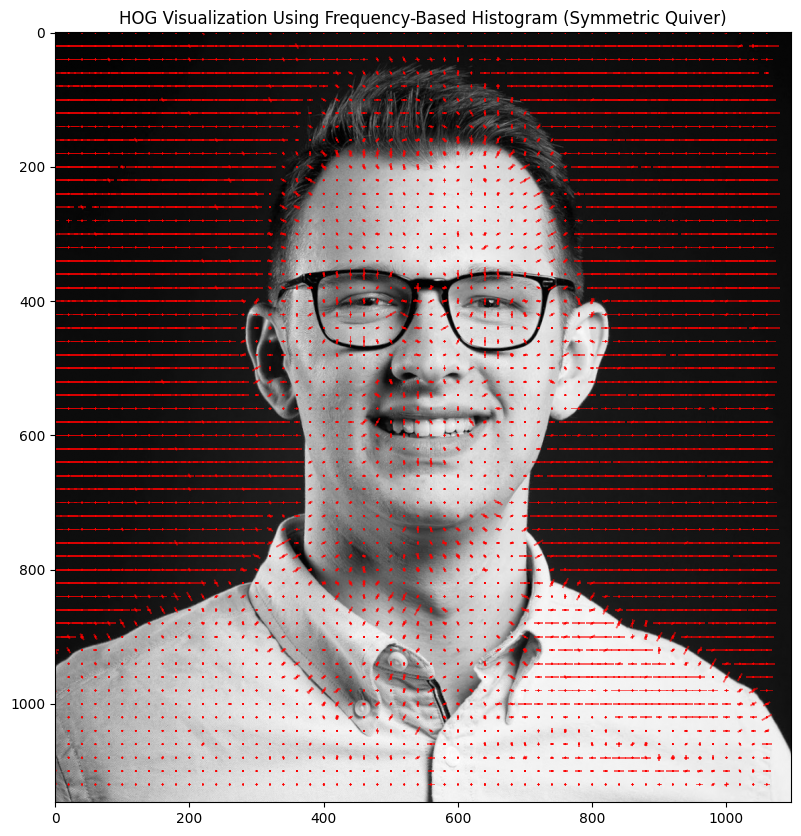

In [62]:
histogram_freq = np.zeros((cell_rows, cell_cols, num_bins))

# Compute histogram frequency instead of summing magnitudes
for i in range(cell_rows):
    for j in range(cell_cols):
        # Extract gradients for the cell
        cell_magnitude = magnitude[i * cell_size: (i + 1) * cell_size,
                                    j * cell_size: (j + 1) * cell_size]
        cell_direction = direction[i * cell_size: (i + 1) * cell_size,
                                    j * cell_size: (j + 1) * cell_size]

        # Quantize the directions into bins (count occurrences instead of sum)
        for k in range(num_bins):
            mask = (cell_direction >= angle_bins[k]) & (cell_direction < angle_bins[k + 1])
            histogram_freq[i, j, k] = np.sum(mask)  # Count occurrences

# Visualization using quiver plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(gray, cmap='gray')

# Superimpose quiver plots
X, Y = np.meshgrid(np.arange(cell_cols) * cell_size, np.arange(cell_rows) * cell_size)

# Normalize the frequency values for a consistent scale
histogram_max = np.max(histogram_freq)
histogram_norm = histogram_freq / (histogram_max + 1e-5)  # Normalize between 0 and 1



# **First loop: Original direction bins**
for k in range(num_bins):
    angle = (angle_bins[k] + angle_bins[k + 1]) / 2  # Midpoint of bin range
    U = np.cos(np.radians(angle)) * histogram_norm[:, :, k] * arrow_scale
    V = np.sin(np.radians(angle)) * histogram_norm[:, :, k] * arrow_scale
    ax.quiver(X, Y, U, V, color='r', angles='xy', scale_units='xy', scale=1,
              alpha=0.6, headwidth=0, headlength=0, headaxislength=0)  # Removes arrowheads

# **Second loop: 180-degree mirrored vectors for symmetry**
for k in range(num_bins):
    angle = (angle_bins[k] + angle_bins[k + 1]) / 2 + 180  # Midpoint + 180°
    U = np.cos(np.radians(angle)) * histogram_norm[:, :, k] * arrow_scale
    V = np.sin(np.radians(angle)) * histogram_norm[:, :, k] * arrow_scale
    ax.quiver(X, Y, U, V, color='r', angles='xy', scale_units='xy', scale=1,
              alpha=0.6, headwidth=0, headlength=0, headaxislength=0)  # Removes arrowheads

plt.title("HOG Visualization Using Frequency-Based Histogram (Symmetric Quiver)")
plt.show()





**Brief Discussion**

The Summed-Gradients approach seems to better capture low frequency features and strong prominent edges. However, the Occurence approach better captures the high frequency features and minute details in the image in a more balanced way. Notice how the first plot only has arrows visible around the profile of the Professor as well as his glasses, and almost no signal from anywhere else. Whereas in the second plot, there is a more gentle flow field around the professors face, however, the background is a lot more noisy too.  

***I prefer the Summed-Gradient approach and will use that going forward primarily***



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# install OpenCV
!pip install opencv-python
import cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Optical Flow

##let's start with sparse optical flow
here we show it on an image pair.

In [ ]:
!wget https://i.ibb.co/NVtJBFR/Peppa.jpg

--2023-03-01 20:29:42--  https://i.ibb.co/NVtJBFR/Peppa.jpg
Resolving i.ibb.co (i.ibb.co)... 104.243.38.177, 104.243.38.202
Connecting to i.ibb.co (i.ibb.co)|104.243.38.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263181 (257K) [image/jpeg]
Saving to: ‘Peppa.jpg’

Peppa.jpg           100%[===================>] 257.01K  --.-KB/s    in 0.1s    

2023-03-01 20:29:42 (1.69 MB/s) - ‘Peppa.jpg’ saved [263181/263181]



(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f32387f9670>)

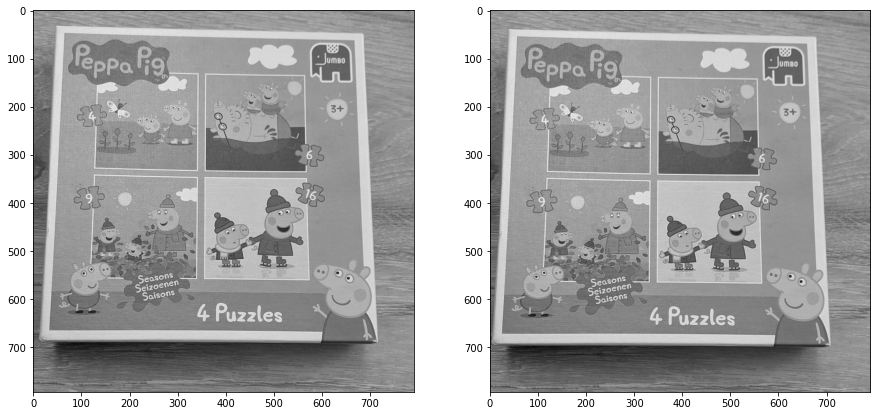

In [ ]:
img = cv2.imread('Peppa.jpg')

shift1 = 7
shift2 = -9

# let's first artificially generate a movement
img_prev = img[shift1:,:shift2,:]
img_current = img[:-shift1,-shift2:,:]

gray_prev = cv2.cvtColor(img_prev, cv2.COLOR_BGR2GRAY)
gray_current = cv2.cvtColor(img_current, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1), plt.imshow(gray_prev, cmap='gray')
plt.subplot(1,2,2), plt.imshow(gray_current,cmap='gray')


In [ ]:
gray_current.shape

(793, 791)

In [ ]:
gray_prev.shape

(793, 791)

In [ ]:
img.shape

(800, 800, 3)

In [ ]:
# select 50 corners using the Shi-Tomasi method
pts_prev = cv2.goodFeaturesToTrack(gray_prev, maxCorners=50, qualityLevel=0.1, minDistance=10)

(([], []), ([], []))

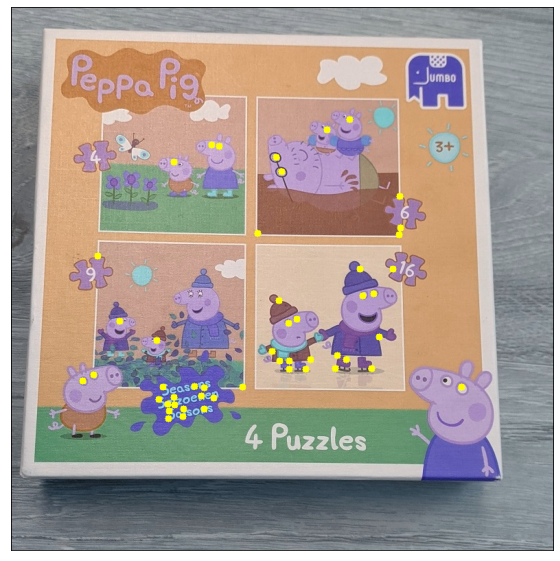

In [ ]:
img_prev_copy = img_prev.copy()

for i in pts_prev:
  x, y = i.ravel()
  cv2.circle(img_prev_copy, (int(x), int(y)), 5, (255,255,0), -1)

plt.figure(figsize=(10,10))
plt.imshow(img_prev_copy)
plt.xticks([]), plt.yticks([])

In [ ]:
# sparse optical flow
opt_flow_params = dict(winSize=(50,50), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10,0.03))
pts_moved, status, err = cv2.calcOpticalFlowPyrLK(gray_prev, gray_current, pts_prev, None, **opt_flow_params)
# look up SparsePyrLKOpticalFlow and SparseOpticalFlow on OpenCV documentations

In [ ]:
print(pts_prev.shape)
print(pts_moved.shape)

(50, 1, 2)
(50, 1, 2)


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f322be79f70>)

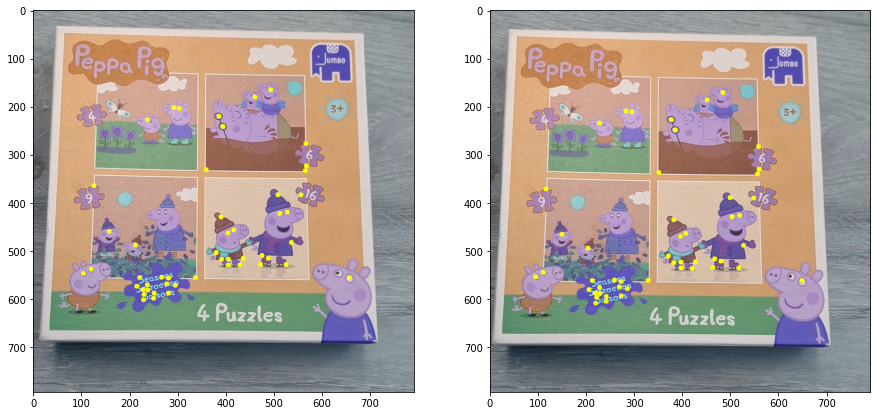

In [ ]:
img_current_copy = img_current.copy()

for i in pts_moved:
  x,y = i.ravel()
  cv2.circle(img_current_copy, (int(x), int(y)), 5, (255,255,0), -1)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1), plt.imshow(img_prev_copy)
plt.subplot(1,2,2), plt.imshow(img_current_copy)

In [ ]:
np.mean(pts_moved - pts_prev, axis=0)

array([[-9.000156 ,  7.0015893]], dtype=float32)

In [ ]:
# mean error (in pixels)
( np.mean(pts_moved - pts_prev, axis=0) - [shift2,shift1] )

array([[-0.0001564,  0.0015893]])

## now let's do dense optical flow on the same image pair
Again, here we show it on an image pair.

In [ ]:
flow = cv2.calcOpticalFlowFarneback(gray_prev, gray_current, None, pyr_scale=0.5, levels=5, winsize=15, iterations=10, poly_n=5, poly_sigma=1.0, flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f322be27a60>)

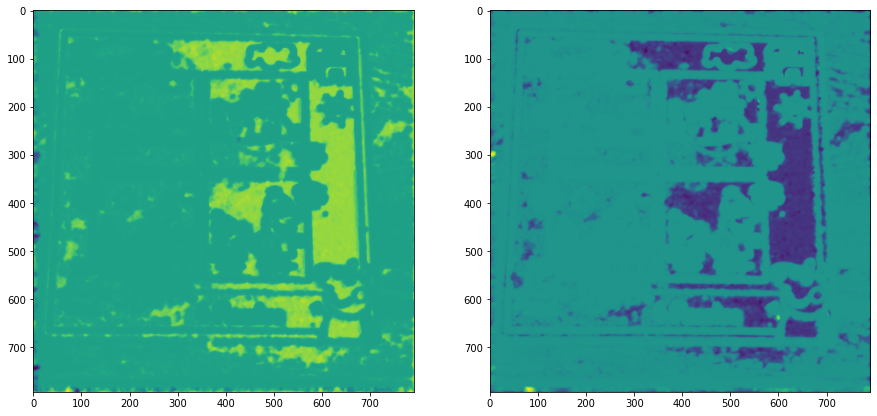

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1), plt.imshow(flow[:,:,0])
plt.subplot(1,2,2), plt.imshow(flow[:,:,1])

In [ ]:
flow[0:5,0:4,0]

array([[ -0.38232592,  -1.1984386 ,  -2.8534448 ,  -4.9197884 ],
       [ -1.2034905 ,  -3.3163054 ,  -6.3156624 ,  -8.68016   ],
       [ -2.6556082 ,  -6.0368357 ,  -9.16005   , -10.789537  ],
       [ -4.2732587 ,  -8.0964775 , -10.629713  , -11.644331  ],
       [ -5.4184723 ,  -9.109916  , -11.16869   , -11.893164  ]],
      dtype=float32)

hmm ... we were expecting them all to be around 7. what's going on?

In [ ]:
flow[0:5,0:4,1]

array([[0.07732642, 0.2681936 , 0.7011213 , 1.3313419 ],
       [0.23058063, 0.71872747, 1.5184472 , 2.307216  ],
       [0.5113008 , 1.3104867 , 2.1974995 , 2.8528569 ],
       [0.8521845 , 1.7962087 , 2.5819495 , 3.101166  ],
       [1.1408554 , 2.1006262 , 2.7909782 , 3.243527  ]], dtype=float32)

In [ ]:
np.median(flow[:,:,0])

-8.92297

that was better!

In [ ]:
np.median(flow[:,:,1])

6.939002